# Autoencoder for Robot Joint Anomaly Detection
**Dataset:** matlab_v1.csv (Robot arm joint angles, velocities, TCP positions)

This notebook implements:
1. Data loading & preprocessing (velocity computation, normalization, noise injection)
2. Automatic latent dimension selection via PCA
3. Lightweight Autoencoder with BatchNorm
4. Training with early stopping
5. Automatic anomaly threshold selection
6. Visualization of results

In [1]:
# =============================================================================
# CELL 1: Install & Import Dependencies
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU device: {tf.config.list_physical_devices('GPU')[0]}")

TensorFlow version: 2.19.0
GPUs available: 1
GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# =============================================================================
# CELL 2: Load Dataset from GitHub
# =============================================================================
CSV_URL = "https://raw.githubusercontent.com/AMRAli-AG/coreX/refs/heads/ai/AI/Datasets/matlab_v1.csv"

print("Loading dataset from GitHub...")
df = pd.read_csv(CSV_URL)

print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

Loading dataset from GitHub...

DATASET OVERVIEW
Shape: (746, 16)

Columns: ['Time', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6', 'TCPx', 'TCPy', 'TCPz']

Data types:
Time    float64
Q1      float64
Q2      float64
Q3      float64
Q4      float64
Q5      float64
Q6      float64
dQ1     float64
dQ2     float64
dQ3     float64
dQ4     float64
dQ5     float64
dQ6     float64
TCPx    float64
TCPy    float64
TCPz    float64
dtype: object

First 5 rows:


,Time,Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,TCPx,TCPy,TCPz
0,0.00,-0.398374,-1.517280,-1.996621,-0.978158,1.091847,1.118422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.318600,0.408000,0.151400
1,0.02,-0.404068,-1.522511,-1.990484,-0.976184,1.093100,1.112164,-0.474118,-0.436266,0.512431,0.163486,0.104509,-0.520864,-0.319166,0.410938,0.152110
2,0.04,-0.409712,-1.527748,-1.984299,-0.974288,1.094357,1.105971,-0.195877,-0.184133,0.219225,0.063137,0.044333,-0.214597,-0.319731,0.413876,0.152821
3,0.06,-0.415304,-1.532990,-1.978069,-0.972469,1.095618,1.099842,-0.315074,-0.295871,0.352052,0.101892,0.071194,-0.345239,-0.320297,0.416814,0.153531
4,0.08,-0.420846,-1.538238,-1.971792,-0.970726,1.096883,1.093776,-0.260010,-0.248022,0.298019,0.079687,0.059856,-0.284325,-0.320862,0.419752,0.154241


In [3]:
# =============================================================================
# CELL 3: Preprocessing - Clean & Prepare Data
# =============================================================================

def preprocess_data(df, add_noise=True, noise_std=0.001):
    """
    Preprocess the robot joint dataset:
    1. Drop time column
    2. Ensure all numeric
    3. Check joint velocities
    4. Optionally add Gaussian noise for robustness
    """
    df_proc = df.copy()
    
    # 1. Drop time column if exists
    time_cols = [c for c in df_proc.columns if 'time' in c.lower()]
    if time_cols:
        print(f"Dropping time column(s): {time_cols}")
        df_proc = df_proc.drop(columns=time_cols)
    
    # 2. Ensure all columns are numeric
    for col in df_proc.columns:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce') # Convert non-numeric to NaN
    
    # Drop rows with NaN
    initial_rows = len(df_proc)
    df_proc = df_proc.dropna()
    if len(df_proc) < initial_rows:
        print(f"Dropped {initial_rows - len(df_proc)} rows with NaN values")
    
    # 3. Check for velocity columns
    joint_cols = [c for c in df_proc.columns if c.startswith('Q') and 'vel' not in c.lower()]
    vel_cols = [c for c in df_proc.columns if c.startswith('dQ') and 'vel' not in c.lower()]
    
    print(f"\nJoint angle columns found: {joint_cols}")
    print(f"Velocity columns found: {vel_cols}")
    
    # 4. Optionally add small Gaussian noise for robustness
    if add_noise:
        print(f"\nAdding Gaussian noise (std={noise_std}) for robustness...")
        noise = np.random.normal(0, noise_std, df_proc.shape)
        df_proc = df_proc + noise
    
    print(f"\nFinal preprocessed shape: {df_proc.shape}")
    print(f"Final columns: {df_proc.columns.tolist()}")
    
    return df_proc

# Run preprocessing
df_processed = preprocess_data(df, add_noise=False, noise_std=0.001)
df_processed.head()

Dropping time column(s): ['Time']

Joint angle columns found: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']
Velocity columns found: ['dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6']

Final preprocessed shape: (746, 15)
Final columns: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6', 'TCPx', 'TCPy', 'TCPz']


,Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,TCPx,TCPy,TCPz
0,-0.398374,-1.517280,-1.996621,-0.978158,1.091847,1.118422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.318600,0.408000,0.151400
1,-0.404068,-1.522511,-1.990484,-0.976184,1.093100,1.112164,-0.474118,-0.436266,0.512431,0.163486,0.104509,-0.520864,-0.319166,0.410938,0.152110
2,-0.409712,-1.527748,-1.984299,-0.974288,1.094357,1.105971,-0.195877,-0.184133,0.219225,0.063137,0.044333,-0.214597,-0.319731,0.413876,0.152821
3,-0.415304,-1.532990,-1.978069,-0.972469,1.095618,1.099842,-0.315074,-0.295871,0.352052,0.101892,0.071194,-0.345239,-0.320297,0.416814,0.153531
4,-0.420846,-1.538238,-1.971792,-0.970726,1.096883,1.093776,-0.260010,-0.248022,0.298019,0.079687,0.059856,-0.284325,-0.320862,0.419752,0.154241


In [4]:
# =============================================================================
# CELL 4: Train/Val Split FIRST (to avoid data leakage)
# =============================================================================

X_raw = df_processed.values

# Split data: 80% train, 20% validation
X_train_raw, X_val_raw = train_test_split(X_raw, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_raw.shape[0]}")
print(f"Validation set size: {X_val_raw.shape[0]}")
print(f"Feature dimension: {X_train_raw.shape[1]}")

Training set size: 596
Validation set size: 150
Feature dimension: 15



PCA ANALYSIS FOR LATENT DIMENSION
Total features: 15
Components for 98% variance: 4
Selected latent dimension: 4


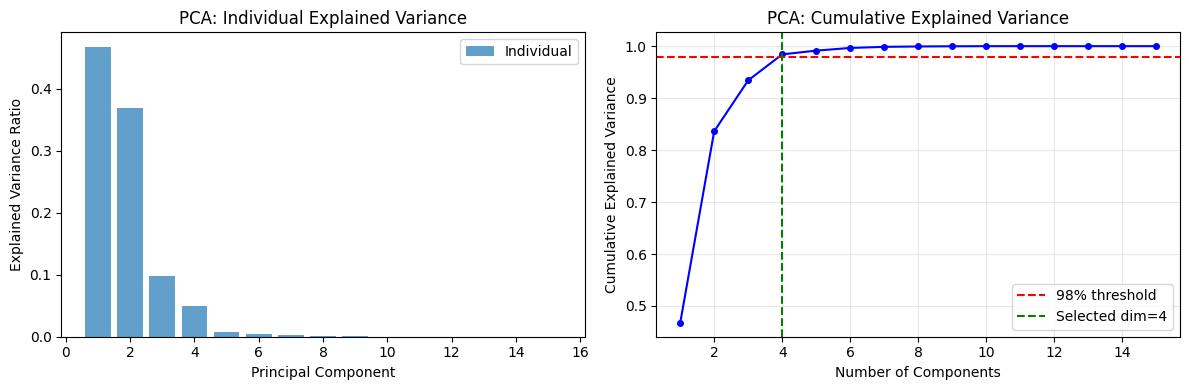

In [5]:
# =============================================================================
# CELL 5: Normalize Data & PCA Analysis
# =============================================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw) 
X_val = scaler.transform(X_val_raw)          

# Use PCA on TRAINING data only to determine latent dimension
pca_full = PCA()
pca_full.fit(X_train) 

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 98% variance
n_components = np.argmax(cumulative_variance >= 0.98) + 1

# Bound between 2 and 16
latent_dim = max(2, min(16, n_components))

print(f"\n{'='*60}")
print("PCA ANALYSIS FOR LATENT DIMENSION")
print(f"{'='*60}")
print(f"Total features: {X_train.shape[1]}")
print(f"Components for 98% variance: {n_components}")
print(f"Selected latent dimension: {latent_dim}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA: Individual Explained Variance')
axes[0].legend()

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-o', markersize=4)
axes[1].axhline(y=0.98, color='r', linestyle='--', label='98% threshold')
axes[1].axvline(x=latent_dim, color='g', linestyle='--', label=f'Selected dim={latent_dim}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA: Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# =============================================================================
# CELL 6: Define Autoencoder Architecture (TensorFlow/Keras)
# =============================================================================

def build_autoencoder(input_dim, latent_dim, dropout_rate=0.05):
    """
    Build a lightweight Autoencoder with BatchNorm using Keras Functional API.
    
    Architecture:
    - Encoder: input -> hidden1 -> hidden2 -> latent
    - Decoder: latent -> hidden2 -> hidden1 -> output
    - BatchNorm after each hidden layer
    - LeakyReLU activations for better gradient flow
    """
    
    # Calculate hidden layer sizes (gradual compression)
    hidden1 = max(32, input_dim * 2)
    hidden2 = max(16, (input_dim))
    
    # Encoder
    encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
    
    x = layers.Dense(hidden1, kernel_initializer='he_normal')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(hidden2, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    latent = layers.Dense(latent_dim, kernel_initializer='he_normal')(x)
    latent = layers.BatchNormalization()(latent)
    latent = layers.LeakyReLU(alpha=0.1, name='latent')(latent)
    
    encoder = Model(encoder_input, latent, name='encoder')
    
    # Decoder (mirror of encoder)
    decoder_input = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    x = layers.Dense(hidden2, kernel_initializer='he_normal')(decoder_input)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    x = layers.Dense(hidden1, kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    decoder_output = layers.Dense(input_dim, kernel_initializer='he_normal', name='decoder_output')(x)
    
    decoder = Model(decoder_input, decoder_output, name='decoder')
    
    # Full Autoencoder
    autoencoder_input = keras.Input(shape=(input_dim,), name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded, name='autoencoder')
    
    return autoencoder, encoder, decoder

# Create model
input_dim = X_train.shape[1]
autoencoder, encoder, decoder = build_autoencoder(input_dim=input_dim, latent_dim=latent_dim, dropout_rate=0.05)

# Compile with MSE loss and Adam optimizer
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

# Model summary
print(f"\n{'='*60}")
print("AUTOENCODER SUMMARY")
print(f"{'='*60}")
autoencoder.summary()

total_params = autoencoder.count_params()
print(f"\nTotal parameters: {total_params:,}")


AUTOENCODER SUMMARY


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 4)              │         1,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 15)             │         1,119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,331 (9.11 KB)

 Non-trainable params: 104 (416.00 B)


Total parameters: 2,435


In [7]:
# =============================================================================
# CELL 7a: Training with Early Stopping
# =============================================================================

# Training configuration
EPOCHS = 500
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 15

print(f"\n{'='*60}")
print("TRAINING AUTOENCODER")
print(f"{'='*60}")
print(f"Epochs: {EPOCHS} (max)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"{'='*60}\n")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOP_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

# Extract losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']

print(f"\nTraining complete!")
print(f"Total epochs run: {len(train_losses)}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")


TRAINING AUTOENCODER
Epochs: 500 (max)
Batch size: 32
Early stopping patience: 15

Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - loss: 1.6401 - val_loss: 0.9308 - learning_rate: 0.0010
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0081 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7877 - val_loss: 0.6411 - learning_rate: 0.0010
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6660 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5869 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5014 - val_loss: 0.3878 - learning_rate: 0.0010
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4465 - val_loss: 0.3367 - learning_rate: 0.0010
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4018 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 9/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 

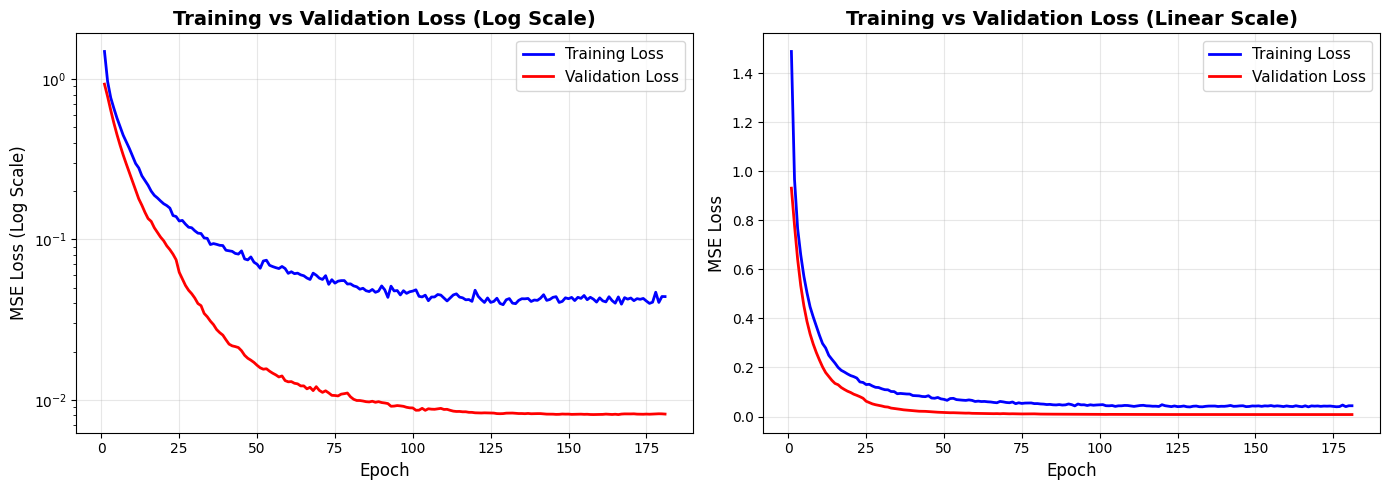

In [8]:
# =============================================================================
# CELL 7b: Training and Validation Loss Curves
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves (Log scale)
ax1 = axes[0]
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss (Log Scale)', fontsize=12)
ax1.set_title('Training vs Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Loss curves (Linear scale)
ax2 = axes[1]
ax2.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.set_title('Training vs Validation Loss (Linear Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
def compute_reconstruction_errors(model, data):
    """Compute per-sample reconstruction errors (MSE)."""
    reconstructed = model.predict(data, verbose=0)
    # Per-sample MSE
    errors = np.mean((data - reconstructed) ** 2, axis=1)
    return errors

# Compute errors on training and validation data
train_errors = compute_reconstruction_errors(autoencoder, X_train)
val_errors = compute_reconstruction_errors(autoencoder, X_val)

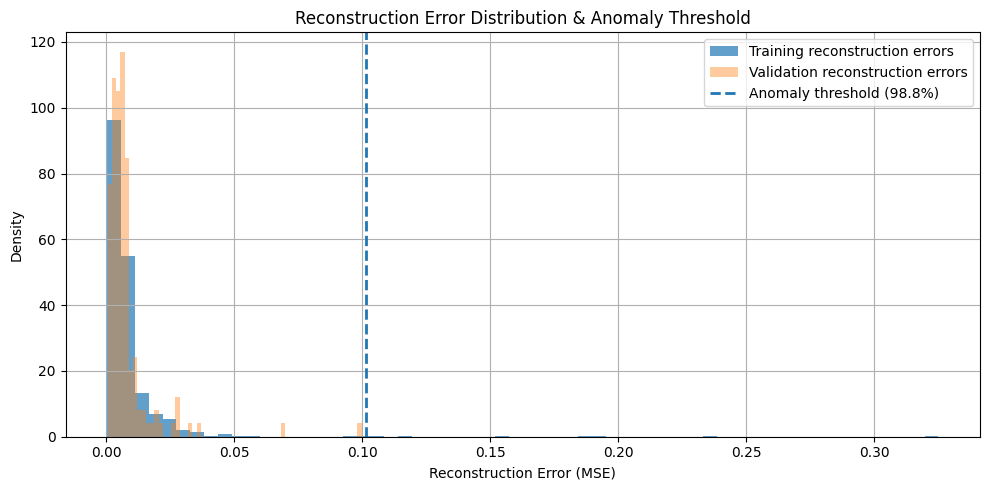

THRESHOLD SANITY CHECK
Selected threshold        : 0.101638
Validation false positives: 0.00%


In [18]:
# =============================================================================
# CELL 8: Visualization-Based Threshold Selection for Anomaly Detection
# =============================================================================

import matplotlib.pyplot as plt

# --------------------------------------------------
# Compute reconstruction errors (already computed)
# train_errors, val_errors
# --------------------------------------------------

# Choose percentile for threshold (conservative)
THRESHOLD_PERCENTILE = 98.8
base_threshold = np.percentile(train_errors, THRESHOLD_PERCENTILE)

threshold = base_threshold 


# --------------------------------------------------
# Plot error distribution
# --------------------------------------------------
plt.figure(figsize=(10, 5))

# Histogram of training errors
plt.hist(
    train_errors,
    bins=60,
    density=True,
    alpha=0.7,
    label="Training reconstruction errors"
)

# Validation errors (lighter overlay)
plt.hist(
    val_errors,
    bins=60,
    density=True,
    alpha=0.4,
    label="Validation reconstruction errors"
)

# Threshold line
plt.axvline(
    threshold,
    linestyle="--",
    linewidth=2,
    label=f"Anomaly threshold ({THRESHOLD_PERCENTILE}%)"
)

plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution & Anomaly Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# Quantitative sanity check
# --------------------------------------------------
fp_rate = np.mean(val_errors > threshold)

print(f"{'='*60}")
print("THRESHOLD SANITY CHECK")
print(f"{'='*60}")
print(f"Selected threshold        : {threshold:.6f}")
print(f"Validation false positives: {fp_rate*100:.2f}%")

In [19]:
# =============================================================================
# CELL 9: Anomaly Detection Function
# =============================================================================

THRESHOLD_MAX = np.max(train_errors)            # Maximum seen in training (0% false positive on training)

# Use MAX threshold as default (safest - 0% false positive on training)
THRESHOLD = THRESHOLD_MAX

def check_point(point, threshold=None):
    """
    Check if a single point is normal or anomaly.
    
    Args:
        point: list or array of feature values (15 features)
        threshold: custom threshold (optional, default=99th percentile)
    
    Returns:
        dict with error, is_anomaly, and status
    """
    if threshold is None:
        threshold = THRESHOLD
    
    point = np.array(point).reshape(1, -1)
    
    # Normalize
    point_normalized = scaler.transform(point)
    
    # Get reconstruction
    reconstructed = autoencoder.predict(point_normalized, verbose=0)
    
    # Calculate error
    error = np.mean((point_normalized - reconstructed) ** 2)
    
    # Check if anomaly
    is_anomaly = error > threshold
    
    # Print result
    status = "ANOMALY" if is_anomaly else "NORMAL"
    print(f"{'='*50}")
    print(f"Point Analysis Result")
    print(f"{'='*50}")
    print(f"Reconstruction Error: {error:.6f}")
    print(f"Threshold used: {threshold:.6f}")
    print(f"Status: {status}")
    
    # Show distance from threshold
    if is_anomaly:
        print(f"Above threshold by: {error - threshold:.6f}")
    else:
        print(f"Below threshold by: {threshold - error:.6f}")
    print(f"{'='*50}")
    
    return {
        'error': error,
        'threshold': threshold,
        'is_anomaly': is_anomaly,
        'status': 'ANOMALY' if is_anomaly else 'NORMAL'
    }

In [20]:
check_point([-2.18714329657152,-1.41244245106878,-2.14557385235776,-0.689062265502895,1.82022805876869,-0.456954226750132,0.110877275550077,0.273516356310998,-0.287714432109106,0.039311166925951,-0.0498081741992509,0.102193693094634,0.328457793617333,0.455617189025004,0.162976575398132])

Point Analysis Result
Reconstruction Error: 0.136904
Threshold used: 0.325071
Status: NORMAL
Below threshold by: 0.188167


{'error': np.float64(0.13690392137476134),
 'threshold': np.float64(0.3250706556103783),
 'is_anomaly': np.False_,
 'status': 'NORMAL'}

In [21]:
check_point([-2.18714329657152,-1.41244245106878,-2.14557385235776,-0.689062265502895,1.82022805876869,-0.456954226750132,0.110877275550077,0.273516356310998,-0.287714432109106,0.039311166925951,-0.0498081741992509,0.102193693094634,0.328457793617333,0.455617189025004,0.162976575398132] + np.random.normal(0, 0.1, 15))  # Add large noise to simulate anomaly

Point Analysis Result
Reconstruction Error: 1.435662
Threshold used: 0.325071
Status: ANOMALY
Above threshold by: 1.110592


{'error': np.float64(1.4356624345306457),
 'threshold': np.float64(0.3250706556103783),
 'is_anomaly': np.True_,
 'status': 'ANOMALY'}

In [ ]:
# =============================================================================
# CELL 10: Export Model for Deployment
# =============================================================================

import joblib
import os

EXPORT_DIR = "AI\Models\\autoencoder"
os.makedirs(EXPORT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(EXPORT_DIR, "autoencoder_model.keras")
autoencoder.save(MODEL_PATH)

SCALER_PATH = os.path.join(EXPORT_DIR, "scaler.pkl")
joblib.dump(scaler, SCALER_PATH)

THRESHOLD_PATH = os.path.join(EXPORT_DIR, "threshold.txt")
with open(THRESHOLD_PATH, "w") as f:
    f.write(str(THRESHOLD))